In [1]:
# proxy
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchvision import transforms, utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import json
from PIL import Image

In [4]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
device = torch.device('cuda')

In [65]:
def load_image(path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    with Image.open(path) as img:
        plt.imshow(img)
        image = Variable(preprocess(img).unsqueeze(0).cuda())
    return image


def predict(image):
    vgg.eval()
    img = image.clone()
    with torch.no_grad():
        out = vgg(img.cuda())
        out = F.softmax(out, dim=1)
        out = out.cpu().data.numpy()
        res = dict(zip(labels, out[0]))
    return res, sorted(res.items(), key=lambda x:x[1], reverse=True)
    

In [6]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

In [7]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [8]:
# modulelist = list(vgg.features.modules())

In [63]:
def occlude(image, occ_size=64, stride=8):
    for i in range(-56, 215, stride):
        for j in range(-56, 215, stride):
            img = image.clone()
            img[:, :, max(0,i):min(224-1,i+occ_size), max(0,j):min(224-1,j+occ_size)] = 0
            yield img
            

def zeiler(image):
    res_d, res_l = predict(image)
    ans_label, accuracy = res_l[0]
    
    heatmap = np.zeros((34,34))
    cnt = 0
    occ  = occlude(image)
    for img in occ:
        res_d, res_l = predict(img)
        heatmap[int(cnt/34), cnt%34] = res_d[ans_label]
        cnt += 1
        
    return heatmap, ans_label
        

In [59]:
occ_size = 64
stride=8

img = myimg.clone()
i = 8
j = -56
img[:, :, max(0,i):min(224-1,i+occ_size), max(0,j):min(224-1,j+occ_size)] = 0
res_d, res_l = predict(myimg)
ans_labels, accuracy = res_l[0]

heatmap = np.zeros((34,34))
cnt = 0
res_d, res_l = predict(img)
heatmap[int(cnt/34), cnt%34] = res_d[ans_labels]

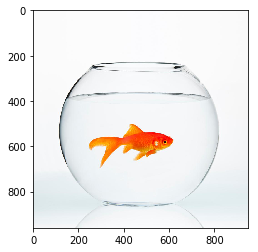

In [68]:
myimg = load_image('./images/goldfish.jpg')

['n01443537', 'goldfish']


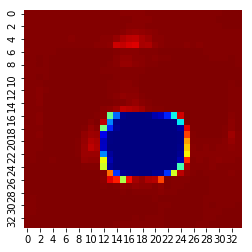

In [70]:
heatmap, ans_label = zeiler(myimg)
print(labels[ans_label])
seaborn.heatmap(heatmap, cmap='jet', square=True, cbar=False)